In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline

import imgaug
import imageio
from imgaug import augmenters as iaa

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras.layers import Dense, GlobalMaxPool2D, BatchNormalization, Dropout, Input
from keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, Nadam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image
from glob import glob
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class DatasetDivision2:

  def __init__(self, root_dir='', output_dir=''):
    self.root_dir = root_dir
    self.output_dir = output_dir
    print('Instance of the class created')

  def divide_dataset(self, root_dir, output_dir):
    self.root_dir = root_dir
    self.output_dir = output_dir

    if os.path.exists(self.output_dir):
      if not os.path.exists(os.path.join(self.output_dir, 'images')):
        os.mkdir(os.path.join(self.output_dir, 'images'))
    else:
      os.mkdir(self.output_dir)
      os.mkdir(os.path.join(self.output_dir, 'images'))

    # creating train, val, test sub folders in each of masks and images folders
    for folder in ['images']:
      if not os.path.exists(os.path.join(self.output_dir, folder, 'train')):
        os.mkdir(os.path.join(self.output_dir, folder, 'train'))
      if not os.path.exists(os.path.join(self.output_dir, folder, 'val')):
        os.mkdir(os.path.join(self.output_dir, folder, 'val'))
      if not os.path.exists(os.path.join(self.output_dir, folder, 'test')):
        os.mkdir(os.path.join(self.output_dir, folder, 'test'))

    # Split train/val/test sets
    for file in os.listdir(root_dir):
      classes_path = os.path.join(root_dir, file)
      class_files = [name for name in glob(os.path.join(classes_path,'*.jpg'))]
      train_and_valid, test = train_test_split(class_files, test_size=0.20, random_state=42)
      train, val = train_test_split(train_and_valid, test_size=0.25, random_state=42)

      # creating the training, validation and testing directories where the data will be copied.
      # for images
      images_train_dir = os.path.join(self.output_dir, 'images', 'train', file)
      images_val_dir = os.path.join(self.output_dir, 'images', 'val', file)
      images_test_dir = os.path.join(self.output_dir, 'images', 'test', file)

      if not os.path.exists(images_train_dir):
        os.mkdir(images_train_dir)
      if not os.path.exists(images_val_dir):
        os.mkdir(images_val_dir)
      if not os.path.exists(images_test_dir):
        os.mkdir(images_test_dir)

      for image_file in train:
        shutil.copy(image_file, images_train_dir)

      for image_file in val:
        shutil.copy(image_file, images_val_dir)

      for image_file in test:
        shutil.copy(image_file, images_test_dir)

      print('Dataset Division Finished for class ' + file)

In [ ]:
path_dir= "/content/drive/MyDrive/Tech-triathlon-2023/Datathon-Dataset"
output_dir = "/content/drive/MyDrive/Tech-triathlon-2023/Datathon-Dataset-Split"
datasetdiv2 = DatasetDivision2(path_dir,output_dir)
datasetdiv2.divide_dataset(path_dir, output_dir)

Instance of the class created
Dataset Division Finished for class category3_tumor
Dataset Division Finished for class category1_tumor
Dataset Division Finished for class category2_tumor
Dataset Division Finished for class no_tumor


In [ ]:
total_count = 0
main_dir = "/content/drive/MyDrive/Tech-triathlon-2023/Datathon-Dataset/"
for classname in os.listdir(main_dir):
  # class_files = [name for name in glob(os.path.join(classname,'*.jpg'))]
  count = 0
  print('Image sizes in ' + classname + ': ')
  for file in os.listdir(os.path.join(main_dir, classname)):
    count += 1
    print(cv2.imread(os.path.join(main_dir, classname, file)).shape)
  print(count)
  total_count += count
print(total_count)

In [ ]:
img = cv2.imread(
    "/content/drive/MyDrive/Tech-triathlon-2023/Datathon-Dataset-Split/divided_datathon_dataset/train/no_tumor/nt_img (58).jpg"
    )
img.shape

(227, 235, 3)

In [ ]:
path = "/content/drive/MyDrive/Tech-triathlon-2023/Datathon-Dataset-Split/divided_datathon_dataset/"

train_datagen = ImageDataGenerator(rescale=1./255, featurewise_center=False,
                                   rotation_range = 5, fill_mode="nearest",
                                   zoom_range=[1/1.0, 1/1.0], width_shift_range=0.0, height_shift_range=0.0,
                                   horizontal_flip = True, vertical_flip=True,
                                   brightness_range=[0.5, 1.3], channel_shift_range=20)

no_DA_IDG = ImageDataGenerator(rescale=1./255)

# in training set: use data augmentation image data generator, for validation and test: no data augmentation.
training_set = train_datagen.flow_from_directory(path+"train/",
                                                target_size=(224, 224), # typical imagenet dimensions
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='categorical', shuffle=True)



validation_set = no_DA_IDG.flow_from_directory(path+"val/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                shuffle=True)



test_set_V2 = no_DA_IDG.flow_from_directory(path+"test/",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)

Found 1938 images belonging to 4 classes.
Found 647 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


In [ ]:
training_set.batch_size

32

In [ ]:
len(next(training_set)[0])

32

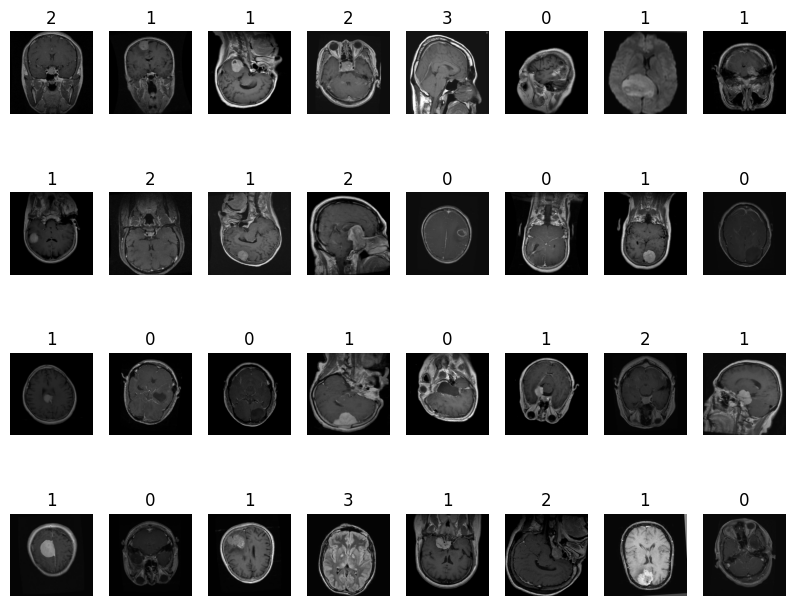

['category1_tumor', 'category2_tumor', 'category3_tumor', 'no_tumor']
4 4


In [ ]:
# Display a batch of images
def show_batch_images(image_batch, labels):
    plt.figure(figsize=(10, 8))
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        plt.imshow(image_batch[i])
        # print(image_batch[i].shape)
        plt.title(np.argmax(labels[i]))  # Display class label
        plt.axis('off')
    plt.show()

# Get a batch of training images and labels
image_batch, label_batch = next(training_set)

# Display the batch of images
show_batch_images(image_batch, label_batch)

# Print class information
classes = sorted(training_set.class_indices.keys())
print(classes)
print(len(classes), len(training_set.class_indices))

In [ ]:
training_set.class_indices

{'category1_tumor': 0,
 'category2_tumor': 1,
 'category3_tumor': 2,
 'no_tumor': 3}

In [ ]:
# Define a function to plot learning curves
def plot_learning_curves(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves - ' + title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Train')
    plt.plot(history.history['val_acc'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves - ' + title)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def model_block(input, num_filters, conv_layer_count):
  x = Conv2D(num_filters, kernel_size = (3,3), padding='same', activation='relu', data_format='channels_last')(input)
  x = Conv2D(num_filters, kernel_size = (3,3), padding='same', activation='relu', data_format='channels_last')(x)
  if conv_layer_count == 3:
    x = Conv2D(num_filters, kernel_size = (3,3), padding='same', activation='relu', data_format='channels_last')(x)
  x = MaxPooling2D(pool_size=(2,2), padding='valid', strides=(2,2), data_format='channels_last')(x)
  return x

In [ ]:
def build_model(input_shape):
  inputs = Input(input_shape)
  x = model_block(inputs, 64, 2)
  x = model_block(x, 128, 2)
  x = model_block(x, 256, 3)
  x = model_block(x, 512, 3)
  mx_y = GlobalMaxPool2D()(x)
  x = BatchNormalization()(mx_y)
  x = Dropout(.5)(x)
  x = Dense(1024, activation='relu', name="dense_1024")(x)
  x = BatchNormalization()(x)
  x = Dropout(.5)(x)
  preds = Dense(4,activation='softmax')(x)
  model = Model(inputs=inputs, outputs=preds)
  return model

In [ ]:
model = build_model((224, 224, 3))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                           

Epoch 1/50

Epoch 1: val_acc improved from -inf to 0.29057, saving model to /content/drive/MyDrive/Tech-triathlon-2023/best_scratch1_adam.h5
61/61 - 1019s - loss: 1.8263 - acc: 0.3937 - val_loss: 4.5198 - val_acc: 0.2906 - lr: 0.0010 - 1019s/epoch - 17s/step
Epoch 2/50

Epoch 2: val_acc improved from 0.29057 to 0.32921, saving model to /content/drive/MyDrive/Tech-triathlon-2023/best_scratch1_adam.h5
61/61 - 31s - loss: 1.6177 - acc: 0.4334 - val_loss: 1.7484 - val_acc: 0.3292 - lr: 0.0010 - 31s/epoch - 508ms/step
Epoch 3/50

Epoch 3: val_acc did not improve from 0.32921
61/61 - 29s - loss: 1.6397 - acc: 0.4082 - val_loss: 1.9918 - val_acc: 0.2056 - lr: 0.0010 - 29s/epoch - 479ms/step
Epoch 4/50

Epoch 4: val_acc improved from 0.32921 to 0.40958, saving model to /content/drive/MyDrive/Tech-triathlon-2023/best_scratch1_adam.h5
61/61 - 31s - loss: 1.4823 - acc: 0.4443 - val_loss: 1.3940 - val_acc: 0.4096 - lr: 0.0010 - 31s/epoch - 515ms/step
Epoch 5/50

Epoch 5: val_acc did not improve fr

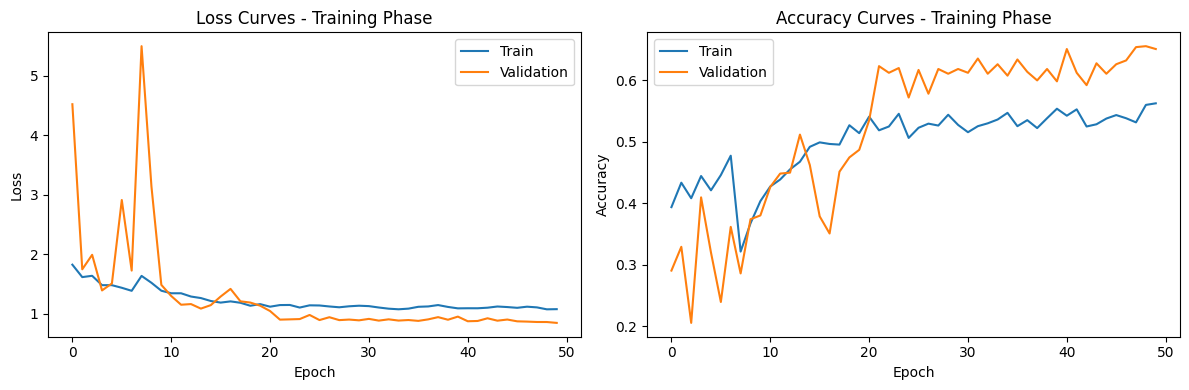

0.6640986132511556
[[105  54  16   9]
 [ 35 120  18  15]
 [ 11  10 157   1]
 [  8  29  12  49]]
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       184
           1       0.56      0.64      0.60       188
           2       0.77      0.88      0.82       179
           3       0.66      0.50      0.57        98

    accuracy                           0.66       649
   macro avg       0.66      0.65      0.65       649
weighted avg       0.66      0.66      0.66       649



In [ ]:
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Tech-triathlon-2023/best_scratch1_adam.h5",  # Path to save the best model
    monitor="val_acc",  # Metric to monitor for saving the best model
    save_best_only=True,  # Only save the best model
    mode="max",  # The higher the better for 'val_acc'
    verbose=1  # Print messages about model saving
)

# Create an EarlyStopping callback to stop training if validation accuracy doesn't improve
early_stopping = EarlyStopping(
    monitor="val_acc",  # Metric to monitor for early stopping
    patience=10,  # Number of epochs with no improvement before stopping
    verbose=1,  # Print messages about early stopping
    restore_best_weights=True  # Restore model to best weights when stopping
)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=5, min_lr=1e-5, verbose=1)

epochs = 50
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_phase = model.fit_generator(generator=training_set,
                                         epochs=epochs,
                                         validation_data=validation_set,
                                         verbose=2,
                                         callbacks=[checkpoint, reduce_lr, early_stopping] )

model.save_weights("/content/drive/MyDrive/Tech-triathlon-2023/best_scratch1_adam_weights.h5")


"""EVALUATE PERFORMANCE ON THE TEST SET"""

y_test = test_set_V2.classes
pred = np.argmax(model.predict_generator(test_set_V2, steps = test_set_V2.n), axis=1)

# Plot Learning Curves
plot_learning_curves(history_phase, "Training Phase")

print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))